# Data Visualization

In [129]:
import scipy.io
import os
import pickle
import random
import cv2 as cv
import numpy as np
from tqdm import tqdm
import numpy as np
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

In [130]:
mat = scipy.io.loadmat('cars_train_annos.mat')
annotations = mat['annotations'][0]

In [131]:
car_classes = {}
for an in annotations:
    an_class = an[4][0][0]
    if an_class in car_classes:
        car_classes[an_class] = car_classes[an_class] + 1
    else:
        car_classes[an_class] = 1
print('There are', len(car_classes), 'classes in this dataset')

There are 196 classes in this dataset


In [132]:
cars_meta = scipy.io.loadmat('cars_meta')
class_names = cars_meta['class_names']
class_names = np.transpose(class_names)

In [133]:
#sort the car_classes 
import operator
sorted_car_classes = sorted(car_classes.items(), key=operator.itemgetter(1),reverse = True)
top10_car_classes = dict(sorted_car_classes[:10])

['GMC Yukon Hybrid SUV 2012', 'Chrysler Crossfire Convertible 2008', 'Nissan Leaf Hatchback 2012', 'Mercedes-Benz C-Class Sedan 2012', 'Jeep Patriot SUV 2012', 'Chevrolet Corvette Ron Fellows Edition Z06 2007', 'Volvo XC90 SUV 2007', 'Volkswagen Beetle Hatchback 2012', 'Bentley Continental Flying Spur Sedan 2007', 'Audi S5 Convertible 2012']


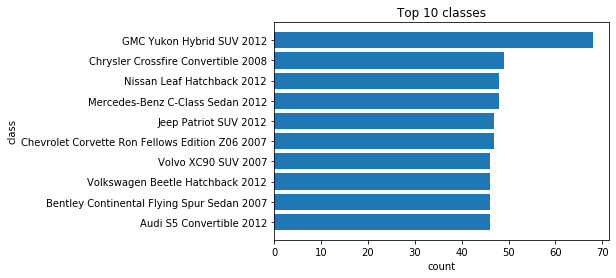

In [134]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#plt.bar(range(len(top10_car_classes)), list(top10_car_classes.values()), align='center')
top10_car_classes_names = []
for k in top10_car_classes.keys():
    top10_car_classes_names.append(class_names[k][0][0])
print(top10_car_classes_names)
#plt.xticks(range(len(top10_car_classes)), top10_car_classes_names)
ax.barh(range(len(top10_car_classes)), list(top10_car_classes.values()), align='center')
ax.set_yticks(range(len(top10_car_classes)))
ax.set_yticklabels(top10_car_classes_names)
ax.invert_yaxis()
plt.xlabel('count')
plt.ylabel('class')
plt.title('Top 10 classes')
plt.show()

# Data Preprocess

In [135]:
cars_annos = scipy.io.loadmat('cars_train_annos.mat')
annotations = cars_annos['annotations']
annotations = np.transpose(annotations)

In [136]:
fnames = []
class_ids = []
bboxes = []
labels = []
for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

In [137]:
labels_count = np.unique(class_ids).shape[0]

In [108]:
#train validation split
num_samples = len(fnames)
train_split = 0.8
num_train = int(round(num_samples * train_split))
train_indexes = random.sample(range(num_samples), num_train)

train = []
valid = []
src_folder = 'cars_train'

In [12]:
for i in tqdm(range(num_samples)):
    fname = fnames[i]
    label = labels[i]
    (x1, y1, x2, y2) = bboxes[i]

    src_path = os.path.join(src_folder, fname)
    src_image = cv.imread(src_path)
    height, width = src_image.shape[:2]
    # margins of 16 pixels
    margin = 16
    x1 = max(0, x1 - margin)
    y1 = max(0, y1 - margin)
    x2 = min(x2 + margin, width)
    y2 = min(y2 + margin, height)
    # print("{} -> {}".format(fname, label))

    if i in train_indexes:
        dst_folder = 'data/train'
    else:
        dst_folder = 'data/valid'

    dst_path = os.path.join(dst_folder, label)
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)
    dst_path = os.path.join(dst_path, fname)

    crop_image = src_image[y1:y2, x1:x2]
    dst_img = cv.resize(src=crop_image, dsize=(224, 224))
    cv.imwrite(dst_path, dst_img)

    if i in train_indexes:
        train.append({'full_path': dst_path, 'label': (int(label) - 1)})
    else:
        valid.append({'full_path': dst_path, 'label': (int(label) - 1)})

print('num_train: ' + str(len(train)))
with open('data/train.pkl', 'wb') as fp:
    pickle.dump(train, fp)

print('num_valid: ' + str(len(valid)))
with open('data/valid.pkl', 'wb') as fp:
    pickle.dump(valid, fp)

100%|██████████| 8144/8144 [02:48<00:00, 48.26it/s]

num_train: 6515
num_valid: 1629


In [109]:
#transform data 
data_transforms = {
    'train': transforms.Compose([
        # transforms.Resize(256),
        # transforms.RandomCrop(224),
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'valid': transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [110]:
class CarRecognitionDataset(Dataset):
    def __init__(self, split):
        filename = 'data/{}.pkl'.format(split)
        with open(filename, 'rb') as file:
            samples = pickle.load(file)

        self.samples = samples

        self.transformer = data_transforms[split]

    def __getitem__(self, i):
        sample = self.samples[i]
        full_path = sample['full_path']
        label = sample['label']
        img = Image.open(full_path)
        img = self.transformer(img)
        return img, label

    def __len__(self):
        return len(self.samples)


In [111]:
train_dataset = CarRecognitionDataset('train')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True,
                                               num_workers=4)
valid_dataset = CarRecognitionDataset('valid')
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False,
                                               num_workers=4)

# Model

In [112]:
# model 
from torch import nn
from torchvision import models

class CarRecognitionModel(nn.Module):
    def __init__(self):
        super(CarRecognitionModel, self).__init__()
        resnet = models.resnet101(pretrained=True) #resnet101
        #resnet = models.resnet34(pretrained=True) #resnet34
        #resnet = models.resnet50(pretrained=True) #resnet50
        #resnet = models.resnet152(pretrained=True) #resnet152
        #alexnet =  models.alexnet(pretrained=True) #alexnet
        #resnext50_32x4d = models.resnext50_32x4d(pretrained=True) #resnext
        # Remove linear layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(2048,196)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, images):
        x = self.resnet(images)  # [N, 2048, 1, 1]
        # x = self.pool(x)
        x = x.view(-1, 2048)  # [N, 2048]
        x = self.fc(x)
        x = self.softmax(x)
        return x

# train

In [113]:
model = CarRecognitionModel()
model = nn.DataParallel(model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9,
                                    weight_decay=1e-6, nesterov=True)

In [114]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Move to GPU, if available
model = model.to(device)

In [115]:
# Loss function
criterion = nn.CrossEntropyLoss()

In [116]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


In [117]:
def accuracy(scores, targets, k=1):
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [118]:
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

In [119]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()  # train mode (dropout and batchnorm is used)

    losses = AverageMeter('Loss', ':.5f')
    accs = AverageMeter('Acc', ':.5f')

    # Batches
    for i, (img, label) in enumerate(train_loader):
        # Move to GPU, if available
        img = img.to(device)  # [N, 3, 224, 224]
        label = label.to(device)  # [N, 196]

        # Forward prop.
        out = model(img)

        # Calculate loss
        loss = criterion(out, label)
        acc = accuracy(out, label)

        # Back prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        clip_gradient(optimizer, 5)

        # Update weights
        optimizer.step()

        # Keep track of metrics
        losses.update(loss.item())
        accs.update(acc)   

    return losses.avg, accs.avg

In [120]:
def valid(valid_loader, model, criterion):
    model.eval()  # eval mode (dropout and batchnorm is NOT used)

    losses = AverageMeter('Loss', ':.5f')
    accs = AverageMeter('Acc', ':.5f')

    # Batches
    for i, (img, label) in enumerate(valid_loader):
        # Move to GPU, if available
        img = img.to(device)  # [N, 3, 224, 224]
        label = label.to(device)  # [N, 196]

        # Forward prop.
        out = model(img)

        # Calculate loss
        loss = criterion(out, label)
        acc = accuracy(out, label)

        # Keep track of metrics
        losses.update(loss.item())
        accs.update(acc)

    return losses.avg, accs.avg


In [68]:
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []
for epoch in range(0, 2):

        lr = 0.01

        # One epoch's training
        train_loss, train_acc = train(train_loader=train_loader,
                                      model=model,
                                      criterion=criterion,
                                      optimizer=optimizer,
                                      epoch=epoch)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        # One epoch's validation
        valid_loss, valid_acc = valid(valid_loader=valid_loader,
                                      model=model,
                                      criterion=criterion)
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)
        print('epoch:', epoch, 'train_loss:', train_loss, 'train_acc', train_acc, 'valid_loss:', valid_loss, 'valid_acc:', valid_acc)



epoch: 0 train_loss: 5.278078293099123 train_acc 0.5821078431372549 valid_loss: 5.277947940078437 valid_acc: 0.7352941176470589
epoch: 1 train_loss: 5.277814022466248 train_acc 1.1795343137254901 valid_loss: 5.2777428720511645 valid_acc: 1.1642156862745099


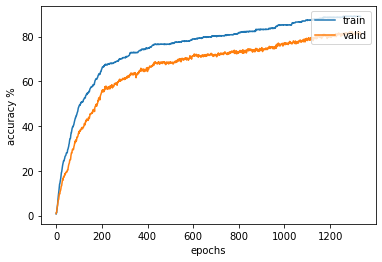

In [32]:
import matplotlib.pyplot as plt
plt.plot(train_acc_list,label = 'train')
plt.plot(valid_acc_list,label = 'valid')
plt.xlabel('epochs')
plt.ylabel('accuracy %')
plt.legend(loc ='upper right')

# Application


In [121]:
LOAD_MODEL_NAME = 'resnet50.sav'

#model = load_checkpoint(LOAD_MODEL_NAME + '.pth')

model = pickle.load(open(LOAD_MODEL_NAME, 'rb'))
model = torch.nn.DataParallel(model)

In [122]:
def process_image(image):
    # Converting image to PIL image using image file path
    pil_im = Image.open(f'{image}' + '.jpg')

    # Building image transform
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]) 
    
    # Transforming image for use with network
    pil_tfd = transform(pil_im)
    
    # Converting to Numpy array 
    array_im_tfd = np.array(pil_tfd)
    
    return array_im_tfd

In [123]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

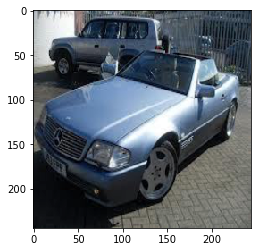

In [124]:
imshow(process_image('cars_test/07039'))

In [125]:
def predict(image_path, model, topk=5):
    # Implement the code to predict the class from an image file   
    
    # Loading model - using .cpu() for working with CPUs
    loaded_model = pickle.load(open(model, 'rb'))
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)
        
    #conf, predicted = torch.max(output.data, 1)   
    probs_top = output.topk(topk)[0]
    predicted_top = output.topk(topk)[1]
    
    # Converting probabilities and outputs to lists
    conf = np.array(probs_top.cpu())[0]
    predicted = np.array(predicted_top.cpu())[0]
        
    #return probs_top_list, index_top_list
    return conf, predicted

In [126]:
def get_name(i):
    return class_names[int(i)-1][0][0]

In [127]:
def predict_car(image_name):
    data_dir = 'cars_test/'
    model_path = 'resnet50.sav'
    image_path = data_dir + image_name

    conf2, predicted1 = predict(image_path, model_path, topk=5)
    # Converting classes to names
    names = []
    for i in range(5):
        names += [get_name(predicted1[i])]

    # Creating PIL image
    image = Image.open(image_path+'.jpg')

    # Plotting test image and predicted probabilites
    f, ax = plt.subplots(2,figsize = (6,10))

    ax[0].imshow(image)
    #ax[0].set_title(get_name(carname))

    y_names = np.arange(len(names))
    ax[1].barh(y_names, conf2/conf2.sum(), color='darkblue')
    ax[1].set_yticks(y_names)
    ax[1].set_yticklabels(names)
    ax[1].invert_yaxis() 

    plt.show()

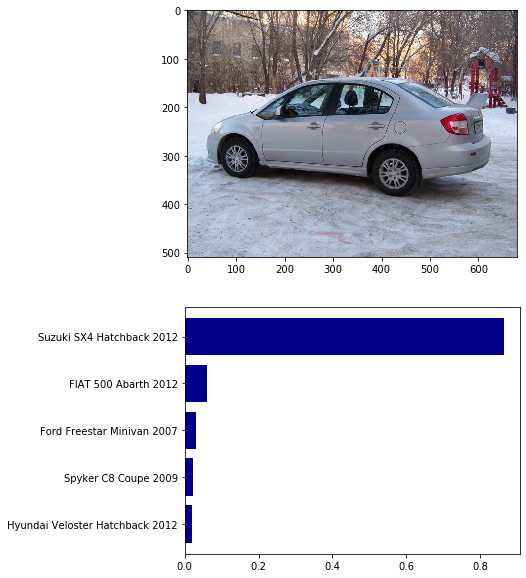

In [128]:
predict_car('00403')